### Source kaggle:
- https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings
- https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words

In [5]:
#!pip3 install wordninja
#!pip3 install pyspellchecker
#!pip3 install text2emotion

In [1]:
import re
import io
import sys

import nltk
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import wordninja
from math import log

import scipy.io as sio

import text2emotion as te
from spellchecker import SpellChecker
from Replacers import Repeat_Letter_Replacer, Antonym_Replacer

from PreprocesingTranscriptions import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def LoadData(fileName):
    Texts, Y_A, Y_C, Y_E, Y_I, Y_N, Y_O = [],[],[],[],[],[],[]
     
    with open('info/transcription_'+fileName+'.pkl', 'rb') as file:
         transcription = pickle.load(file, encoding='latin1')
    
    with open('info/annotation_'+fileName+'.pkl', 'rb') as file:
         annotation = pickle.load(file, encoding='latin1')

    for key in transcription.keys():
        Texts.append(transcription[key])
        
        Y_A.append(annotation['agreeableness'][key])
        Y_C.append(annotation['conscientiousness'][key])
        Y_E.append(annotation['extraversion'][key])
        Y_N.append(annotation['neuroticism'][key])
        Y_O.append(annotation['openness'][key])
        Y_I.append(annotation['interview'][key])
    
    OCEAN = {'AGRE' : Y_A, 'CONS' : Y_C, 'EXTR' : Y_E,
             'NEUR' : Y_N, 'OPEN' : Y_O, 'INTER' : Y_I}   

    df = pd.DataFrame()
    #df['Ids'] = list(transcription.keys())
    df['Transcript'] = Texts
    for key in OCEAN.keys():
        df[key] = OCEAN[key]
    df.to_csv('Dataset/'+fileName+'.csv', index=False, header=True)
    
    return df    
        
def LoadDataSet():
    LoadData('training')
    LoadData('validation')
    LoadData('test')
    
    print('Dataset OCEAN Loaded')
    
LoadDataSet()

Dataset OCEAN Loaded


## High level preprocessing

In [4]:
Train_df = pd.read_csv("Dataset/training.csv")
Val_df = pd.read_csv("Dataset/validation.csv")
Test_df = pd.read_csv("Dataset/test.csv")
print('Dataset OCEAN Loaded', Train_df.shape[0], Val_df.shape[0], Test_df.shape[0])
#print(len(list(set(Train_df.Ids))), len(list(set(Val_df.Ids))), len(list(set(Test_df.Ids))))
Train_df.dropna(subset = ["Transcript"], inplace=True)
Val_df.dropna(subset = ["Transcript"], inplace=True)
Test_df.dropna(subset = ["Transcript"], inplace=True)

Train_df.shape[0], Val_df.shape[0], Test_df.shape[0]

Dataset OCEAN Loaded 6000 2000 2000


(5992, 2000, 1997)

In [5]:
Urls = ['stephaniechats.com', 'YouTube.com/bradwest.', 'sephora.com', 'patreon.com', 'audible.com', 'citicom.net', 'Amazon.com',
        'musical.ly', 'MassageWarehouse.com', 'DrugFreeAZ.org', 'DrugFreeAZKids.org', '@gmail.com', 'growingyourgreens.com',
        'facebook.com/themounteframescenter', 'lifeonfire.com', 'lifeonfirequestions.com', 'facebook.com/berneseoftherockies', 
        'askmygirlfriend.com', 'Easydivorcequestions.com', 'webereptiles.net', 'shopsignorelli.com', 'support.tm', 'perfectlyplantbased.com',
        'grinddayfromwork.com', 'facebook.com/groups-', 'epicbeautyguide.com', 'AboveTheInfluence.com', 'www.bigbadeu.weebly.com',
        'Store.BensKarts.com', 'coupons.com', 'helloscheduling.com', 'anycoupons.com', 'therockies.com', 'Revlon.com/lovestest.',]

Emails = ['Geektofreakfitness@gmail.com', 'asliminc@gmail.com', 'frugalfilmmaker@gmail.com', 'rachel@rachelemilio.com', 'Luke@redmattersite.com',
          'Videos@mail.com', 'holdernessvideos@gmail.com', '...@gmail.com', 'yyainternationalagency@gmail.com', 'ddzeets@ddzeets.']

Acronyms = ['B.', 'J.L.', 'U.', 'U.S.', 'C.T.', 'P.M.', 'X.', 'O.', 'J.C.', 'K.', 'R.', 'R.R.', 'T.V.', 'A.E.I.O.U.',
            'S.', 'M.M.M.', 'M.', 'W.W.', 'P.S.', 'J.', 'C.S.', 'D.', 'J.K.', 'G.', 'R.B.I.', 'A.', 'L.', 'Z.', 'W.', 'I.']

Punctuations = ["'", ',', '.', '"', '!', '-', '?', ':', '[', ']', '&', '(', ')', ';', '/', '#', '…', '’', 'é', '@', '_', '+', 'ñ',
                '*', '=', 'è', '¢']

Dict = {'HIIT':'hit','DIPBROW':'eyebrow','ITC':'company','MILF':'sexy mother','MLP':'my little pony','GTR':'car',
        'Q&A':'question answer','Q & A':'question answer','q & a':'question answer','H&M':'clothing company','q&a':'question answer', 
        'H & M':'clothing company','PX&I':'her and i','rap':'hip hop music','R&B':'rythm and blues','D&D':'dungeons and dragons',
        'FAQs':'frequent asked question', 'FAQ':'frequent asked question','UCLA':'University of California Los Angeles',
        'URL':'link','JR':'junior','GTA':'game','US':'united states','NASA':'national aeronotics and space administration', 
        'L.A.':'los angeles','U.S.':'united states','U.A.E.':'united arab emirates','T.V.':'television','P.S.':'playstation',
        'USA':'united states of america','LA':'los angeles','BMW':'car','FIFA':'football federation','IS':'is','YES':'yes',
        'LGBT':'lesbian, bisexual, gay and transgender','XBOX':'video game','KFC':'fried chicken restaurent','ISIS':'terrorism','JPEG':'image',
        'OS':'operating system','EU':'european union','MAC':'computer company','XL':'big size','OPEC':'petroleum organization',
        'NBC':'television channel','ASK':'ask','BEEP':'beep','OK':'okay','GPS':'global positioniong system','XP':'operatin system',
        'WWE':'world wrestling entertainment','WWF':'world wrestling federation','HR':'human resources','PC':'personal computer',
        'TV':'television','DNA':'genetic code','ISO':'standards','DJ':'disc jockey','ACM':'music organization','FBI':'police',
        'CV':'personal resume','CVs':'personal resume','DC':'capital','LOL':'laugh out loud','DVD':'digital disc',
        'CD':'digital disc','LG':'electronics company','GF':'girlfriend','CEO':'chief administrator','UK':'united kingdom',
        'ICE':'ice','LET':'let','PRO':'professional','UFC':'fighting championship organization','PDF':'electronic document',
        'DR':'doctor','UP':'up','UPS':'ups','IO':'input output','NBA':'national basketball association','DOW':'industrial average',
        'DO':'do','SO':'so','IN':'in','CIA':'central intelligence agency','WE':'we','IRL':'in real life','TMZ':'online newspaper',
        'USB':'universal serial bus','RAM':'memory','NYC':'new york city','BFF':'best friends forever','BM': 'car',
        'Bitcon':'money','bitcoin':'money','Xboxes':'video games','webinar':'web conferencing','pics':'pictures','someon':'someone',
        'everyb':'everybody','Zumba':'dance','protheif':'professional theif','takeaway':'restaurent','homeschool':'home education',
        'cuz':'because','excample':'example','collab':'collaboration','mforfaith':'i am for faith','boysandpizza':'boys and pizza',
        'overthink':'think too much','transactionary':'transaction','unaffordable':'expensive','bestest':'best','unathletic':'not athletic',
        'liquidy':'liquid','unscripted':'with no prepared script','kissable':'good to kiss','blurriness':'not clear','stupidist':'very stupid',
        'unorganizedness':'not organized','unprocessed':'not processed','weirdish':'weird','instable':'not stable','yur':'your','beaut':'beauty',
        'boutiquey':'boutique','chairside':'chair side','wisha':'wish','dissolvable':'capable of dissolving','Christmasy':'christmas',
        'prob':'problem','coz':'because','physio':'physiotherapy','matchy':'match','energetical':'energetic','empathic':'empathy',
        'IFBB':'international federation of body building','underdressed':'too informally clothed','snacky':'snack','hashtag':'tag',
        'auntie':'aunt','urrr':'your','Fanfest':'event for fans','fav':'favorite','flavorous':'have flavor',
       }

In [6]:
def extract_nouns_adj_adv(Texts):
    nouns, adjectives, adverbs = [], [], []
    for sentence in Texts:
        for word, pos in nltk.pos_tag(nltk.word_tokenize(str(sentence))):
            if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
                nouns.append(word)
            if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS'):
                adjectives.append(word)
            if (pos == 'RB' or pos == 'RBR' or pos == 'RBS'):
                adverbs.append(word)
    return list(set(nouns)), list(set(adjectives)), list(set(adverbs))

def Vocabulary(Text):
    Voc = []
    words = open("EnglishDictionary/words-by-frequency.txt").read().split()

    words_not_in_Dict = []
    for word in Text.split(' '):
        if not word.lower() in words:
            words_not_in_Dict.append(word)
        else:
             Voc.append(word)
    with open('words_not_in_Dict.txt','w') as f:
         for index, word in enumerate(list(set(words_not_in_Dict))):
            f.write(word + '\n')
            if index % 200 == 0:
                f.write('______________________\n')
    return list(set(Voc)), list(set(words_not_in_Dict))

def Replace_All(Text, patterns, Replacment):
    for pattern in patterns:
        if pattern in Text:
            Text = Text.replace(pattern, Replacment)
    return Text

def Replace_Dict(Text, Dict): 
    for token in Text.split():
        if token in Dict.keys():
            Text = Text.replace(token, Dict[token])
    return Text

In [7]:
#https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
def infer_spaces(s):
    # Build a cost dictionary, assuming Zipf's law and cost = -math.log(probability).
    words = open("EnglishDictionary/words-by-frequency.txt").read().split()
    wordcost = dict((k, log((i+1)*log(len(words)))) for i,k in enumerate(words))
    maxword = max(len(x) for x in words)

    """Uses dynamic programming to infer the location of spaces in a string
    without spaces."""

    # Find the best match for the i first characters, assuming cost has
    # been built for the i-1 first characters.
    # Returns a pair (match_cost, match_length).
    def best_match(i):
        candidates = enumerate(reversed(cost[max(0, i-maxword):i]))
        return min((c + wordcost.get(s[i-k-1:i], 9e999), k+1) for k,c in candidates)

    # Build the cost array.
    cost = [0]
    for i in range(1,len(s)+1):
        c,k = best_match(i)
        cost.append(c)

    # Backtrack to recover the minimal-cost string.
    out = []
    i = len(s)
    while i>0:
        c,k = best_match(i)
        assert c == cost[i]
        out.append(s[i-k:i])
        i -= k
    return out[::-1]
    return " ".join(reversed(out))

In [8]:
def Emotion_Recognition(Texts, fileName):
    emotions = []
    i = 1
    for Text in Texts:
        if str(Text) != 'nan':
            emotions.append(list(te.get_emotion(Text).values()))
        else:
            emotions.append(float('nan'))
        sys.stdout.write('\rTranscription %d/%d %s' %(i, len(Texts), Text))
        sys.stdout.flush()
        i +=1
    
    emotions = np.array(emotions)    

    df = pd.DataFrame()
    df['Transcript'] = Texts
    df['Happy'] = emotions[:,0]
    df['Angry'] = emotions[:,1]
    df['Surprise'] = emotions[:,2]
    df['Sad'] = emotions[:,3]
    df['Fear'] = emotions[:,4]
    df.to_csv('Emotions/'+fileName+'.csv', index=False, header=True)
    
    return df

In [9]:
def correct_phrases(words_not_in_Dict):
    words = open("EnglishDictionary/words-by-frequency.txt").read().split()
    phrase_not_in_Dict = {k:True for k in words_not_in_Dict}
    
    spell = SpellChecker()
    RepeatReplacer = Repeat_Letter_Replacer()

    for phrase in words_not_in_Dict:
        correct_phrase = RepeatReplacer.replace(phrase)
        correct_phrase = spell.correction(correct_phrase)
        if correct_phrase != phrase:
            if correct_phrase in words:
                phrase_not_in_Dict[phrase] = correct_phrase
        else:
            Tokens = infer_spaces(phrase)
            correct_tokens = []
            for token in Tokens:
                if token in words:
                    correct_tokens.append(token)
                else:
                    T = spell.correction(RepeatReplacer.replace(token))
                    if T in words:
                        correct_tokens.append(T)
            phrase_not_in_Dict[phrase] = ' '.join(correct_tokens)  
    return phrase_not_in_Dict

def Separate_phrases(words_not_in_Dict):
    words = open("EnglishDictionary/words-by-frequency.txt").read().split()
    phrases = {k:True for k in words_not_in_Dict}

    for phrase in words_not_in_Dict:
        Tokens = []
        for token in infer_spaces(phrase):
            if len(token) > 2 and token in words:
                Tokens.append(token)
            phrases[phrase] = ' '.join(Tokens)  
    return phrases

In [10]:
Texts = Train_df['Transcript'].tolist() + Val_df['Transcript'].tolist() + Test_df['Transcript'].tolist()
for text in Texts:
    for token in text.split():
        if 'P.S.' == token:
            print(text)
            break

"You guys suggest a lot of games. P.S. If you still think the, '"Me, Me, Me,"' music video was weird, then I challenge you to watch York's, '"I miss you"' official clip."
Sports, if so what? P.S. I love your channel, I'm so obsessed. Thank you so much, and yeah and yeah. I do not play any sports. Freshman year I did track, but that was not my thing.
I am going to give something for my sister and then something for my parents. Lucy asks Christmas or the buildup to Christmas, P.S. I love you so much. I love you too. This is actually really hard because-


In [11]:
RegReplacer = RegexpReplacer()

#Text = ' '.join(Train_df['Transcript'].tolist() + Val_df['Transcript'].tolist() + Test_df['Transcript'].tolist())

#Urls = Extract_URLs(Text)
#Emails = Extract_emails(Text)
#Acronyms = Extract_Acronyms(Text)
#Punctuations = List_Punctuations(Text)
    
#print(Urls)
#print('________________________',len(Urls))
#print(Emails)
#print('________________________',len(Emails))
#print(Acronyms)
#print('________________________',len(Acronyms))
#print(Punctuations)
#print('________________________',len(Punctuations))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: Replace_All(x, Urls, ' link '))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: Replace_All(x, Urls, ' link '))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: Replace_All(x, Urls, ' link '))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: Replace_All(x, Emails, ' email '))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: Replace_All(x, Emails, ' email '))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: Replace_All(x, Emails, ' email '))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: Replace_All(x, Acronyms, ' '))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: Replace_All(x, Acronyms, ' '))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: Replace_All(x, Acronyms, ' '))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: re.sub(r"\S*\d\S*", ' ', x))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: re.sub(r"\S*\d\S*", ' ', x))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: re.sub(r"\S*\d\S*", ' ', x))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: RegReplacer.replace(x))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: RegReplacer.replace(x))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: RegReplacer.replace(x))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: x.replace(' & ','&'))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: x.replace(' & ','&'))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: x.replace(' & ','&'))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: Replace_Dict(x, Dict))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: Replace_Dict(x, Dict))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: Replace_Dict(x, Dict))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: Replace_All(x, Punctuations, ' '))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: Replace_All(x, Punctuations, ' '))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: Replace_All(x, Punctuations, ' '))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: Split_uppercase(x))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: Split_uppercase(x))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: Split_uppercase(x))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: ' '.join([word for word in x.split() if not word.isupper()]))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: ' '.join([word for word in x.split() if not word.isupper()]))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: ' '.join([word for word in x.split() if not word.isupper()]))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: re.sub(r"\s+", " ",x.lower()).strip())
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: re.sub(r"\s+", " ",x.lower()).strip())
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: re.sub(r"\s+", " ",x.lower()).strip())

In [12]:
Text = ' '.join(Train_df['Transcript'].tolist() + Val_df['Transcript'].tolist() + Test_df['Transcript'].tolist())
Voc, words_not_in_Dict = Vocabulary(Text)

Stopwords = [w for w in words_not_in_Dict if len(w)<5]
between = [w for w in words_not_in_Dict if len(w)>5 and len(w)<10]
To_be_separated = [w for w in words_not_in_Dict if len(w)>=10]
phrases = Separate_phrases(To_be_separated)

In [13]:
len(Voc), len(words_not_in_Dict), len(Stopwords), len(between), len(To_be_separated), len(phrases)

(12811, 1310, 142, 729, 224, 224)

In [14]:
Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: Replace_Dict(x, phrases))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: Replace_Dict(x, phrases))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: Replace_Dict(x, phrases))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: ' '.join([word for word in x.split() if word not in (Stopwords)]))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: ' '.join([word for word in x.split() if word not in (Stopwords)]))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: ' '.join([word for word in x.split() if word not in (Stopwords)]))

Train_df['Transcript'] = Train_df['Transcript'].apply(lambda x: ' '.join([phrases[word] if word in (phrases) else word for word in x.split()]))
Val_df['Transcript'] = Val_df['Transcript'].apply(lambda x: ' '.join([phrases[word] if word in (phrases) else word for word in x.split()]))
Test_df['Transcript'] = Test_df['Transcript'].apply(lambda x: ' '.join([phrases[word] if word in (phrases) else word for word in x.split()]))

In [15]:
Train_df

,Transcript,AGRE,CONS,EXTR,NEUR,OPEN,INTER
0,he is cutting it and then turn around and see ...,0.626374,0.601942,0.523364,0.552083,0.488889,0.504673
1,responsibility to house the organ had been giv...,0.472527,0.582524,0.345794,0.375000,0.366667,0.457944
2,actually got quite a few sets of black pens th...,0.406593,0.485437,0.252336,0.291667,0.511111,0.373832
3,ate a lot would like a lot of foods remember h...,0.505495,0.398058,0.457944,0.489583,0.377778,0.457944
4,now will ask you guys to leave a question in t...,0.406593,0.621359,0.607477,0.489583,0.622222,0.570093
...,...,...,...,...,...,...,...
5995,got to see a lot got to experience a lot yeah ...,0.571429,0.485437,0.401869,0.427083,0.466667,0.485981
5996,really really love my job love the people work...,0.582418,0.524272,0.728972,0.760417,0.822222,0.616822
5997,have a nine to five said this in my last do no...,0.747253,0.699029,0.700935,0.770833,0.788889,0.691589
5998,you want to be working with and who you want t...,0.582418,0.679612,0.317757,0.531250,0.588889,0.616822


In [16]:
seq_len = np.array([len(i.split()) for i in Train_df['Transcript'].tolist()])

for i in range(0, 11):
    print(i, np.count_nonzero(seq_len==i))

0 1
1 14
2 10
3 12
4 10
5 10
6 9
7 20
8 13
9 18
10 13


c:\program files\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendere

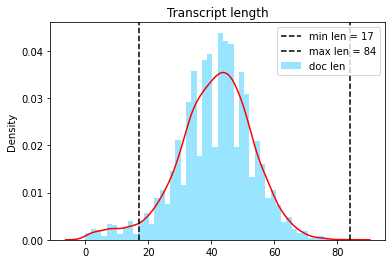

In [17]:
#visualize word distribution
seq_len = np.array([len(i.split()) for i in Train_df['Transcript'].tolist()])
Train_df['Trans_len'] = Train_df['Transcript'].apply(lambda words: len(words.split(" ")))
Val_df['Trans_len'] = Val_df['Transcript'].apply(lambda words: len(words.split(" ")))
Test_df['Trans_len'] = Test_df['Transcript'].apply(lambda words: len(words.split(" ")))

min_seq_len = np.round(np.mean(seq_len) - np.std(seq_len)*2).astype(int)#7
max_seq_len = np.round(np.mean(seq_len) + np.std(seq_len)*2).astype(int)
max_seq_len = np.max(seq_len)

sns.distplot(seq_len, hist=True, kde=True, kde_kws={"color": "r"}, color='deepskyblue', label='doc len')
plt.axvline(x=min_seq_len, color='k', linestyle='--', label='min len = '+str(min_seq_len))
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len = '+str(max_seq_len))

plt.title('Transcript length'); plt.legend()

plt.savefig('Transcript_Length.eps', format='eps', dpi=1000)

plt.show()

In [18]:
Train_df0 = Train_df[Train_df.Trans_len >= min_seq_len]
Val_df0 = Val_df[Val_df.Trans_len >= min_seq_len]
Test_df0 = Test_df[Test_df.Trans_len >= min_seq_len]
Train_df.shape[0], Val_df.shape[0], Test_df.shape[0]

(5992, 2000, 1997)

In [19]:
Train_df0.to_csv('Dataset/Train.csv', index=False, header=True)
Val_df0.to_csv('Dataset/Validation.csv', index=False, header=True)
Test_df0.to_csv('Dataset/Test.csv', index=False, header=True)

In [21]:
Edf_Train = Emotion_Recognition(Train_df['Transcript'].tolist(), 'Emotions_Train')
Edf_Val = Emotion_Recognition(Val_df['Transcript'].tolist(), 'Emotions_Validation')
Edf_Test = Emotion_Recognition(Test_df['Transcript'].tolist(), 'Emotions_Test')

Transcription 1941/1941 eat enough carbs eat more fats to get in more calories think that is basically it actually you can post maybe in commentses not just boom come out of nowhere you actually have to provide it with the building blocks the calories protein carbs fats everythingworks do not know do not knowmitch before but she is likee little one on one that onensogs which do do whichnk you all for the recenth two plates am like